# **Single-Cell RNA-Seq Analysis Project**

In this project, you will work with the `norman` dataset from the `perturbation_data_analysis` exercise:

In [2]:
from models import Autoencoder
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
%matplotlib inline

c:\Users\Yucel\Documents\__WS 24-25\AMLG\AMLG-Course-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

from src.projects.scrnaseq_project import pertdata as pt  # noqa: E402

norman = pt.PertData.from_repo(name="norman", save_dir="data")

print(norman)

Dataset directory already exists: data\norman
Loading dataset: norman
PertData object
    name: norman
    path: data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045


**Exploratory Data Analysis and Visualization**

In [8]:
print(norman)
print(norman.adata)

X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]

print(f"X.shape={X.shape}")  # type: ignore
print(f"y_pert.shape={y_pert.shape}")
print(f"y_ctrl.shape={y_ctrl.shape}")
print(f"gene_names.shape={gene_names.shape}")

PertData object
    name: norman
    path: data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
X.shape=(91205, 5045)
y_pert.shape=(91205,)
y_ctrl.shape=(91205,)
gene_names.shape=(5045,)


In [9]:
print(f"Unique perturbations (unfixed): {len(set(norman.adata.obs['condition']))}")
print(f"Unique perturbations (fixed): {len(set(norman.adata.obs['condition_fixed']))}")

Unique perturbations (unfixed): 284
Unique perturbations (fixed): 237


**Filtering out double gene perturbations**

In [10]:
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()  # type: ignore

In [11]:
print(filter_mask)
print(indexes_to_keep)
print(adata_single)

print("")
print(f"Unique perturbations: {len(set(adata_single.obs['condition_fixed']))}")
print("Number of samples per condition:")
print(adata_single.obs["condition_fixed"].value_counts())

cell_barcode
AAACCTGAGGCATGTG-1     True
AAACCTGAGGCCCTTG-1    False
AAACCTGCACGAAGCA-1     True
AAACCTGCAGACGTAG-1    False
AAACCTGCAGCCTTGG-1     True
                      ...  
TTTGTCAGTCATGCAT-8    False
TTTGTCATCAGTACGT-8     True
TTTGTCATCCACTCCA-8     True
TTTGTCATCCCAACGG-8     True
TTTGTCATCTGGCGAC-8     True
Name: condition_fixed, Length: 91205, dtype: bool
Index(['AAACCTGAGGCATGTG-1', 'AAACCTGCACGAAGCA-1', 'AAACCTGCAGCCTTGG-1',
       'AAACCTGCATCTCCCA-1', 'AAACCTGGTATAATGG-1', 'AAACCTGGTCTGATTG-1',
       'AAACCTGGTTTCCACC-1', 'AAACCTGTCAGGCGAA-1', 'AAACCTGTCCGATATG-1',
       'AAACCTGTCCGTAGTA-1',
       ...
       'TTTGTCACATCGTCGG-8', 'TTTGTCAGTACCTACA-8', 'TTTGTCAGTACGCTGC-8',
       'TTTGTCAGTAGCGTGA-8', 'TTTGTCAGTAGGCATG-8', 'TTTGTCAGTCAGAATA-8',
       'TTTGTCATCAGTACGT-8', 'TTTGTCATCCACTCCA-8', 'TTTGTCATCCCAACGG-8',
       'TTTGTCATCTGGCGAC-8'],
      dtype='object', name='cell_barcode', length=55760)
AnnData object with n_obs × n_vars = 55760 × 5045
    obs: 'cond

**Selecting highest variances**

In [12]:
# Number of top genes to select.
d = 128

# Compute the gene variances.
gene_variances = adata_single.X.toarray().var(axis=0)  # type: ignore

# Sort the gene variances in descending order and get the indexes of the top d genes.
sorted_indexes = gene_variances.argsort()[::-1]

# Get the indexes of the top d genes.
top_gene_indexes = sorted_indexes[:d]

# Get the gene names of the top d genes.
top_genes = adata_single.var["gene_name"].iloc[top_gene_indexes]

# Get the variances of the top d genes.
top_variances = gene_variances[top_gene_indexes]

# Print the top d genes with the highest variances.
print(f"Top {d} genes with highest variances:")
for gene, variance in zip(top_genes, top_variances):
    print(f"{gene:15}: {variance:.2f}")
    # print(str(gene) + ", " + str(variance))

# Create a new AnnData object with only the top d genes.
adata_single_top_genes = adata_single[:, top_gene_indexes].copy()

Top 128 genes with highest variances:
HBZ            : 1.69
HIST1H4C       : 1.69
HBG2           : 1.15
HIST1H1C       : 0.85
HBG1           : 0.73
NEAT1          : 0.71
UBE2S          : 0.62
GYPB           : 0.61
MALAT1         : 0.58
TOP2A          : 0.58
VIM            : 0.57
HMGB2          : 0.56
SH3BGRL3       : 0.55
RP11-301G19.1  : 0.53
HIST1H2BJ      : 0.52
CENPF          : 0.49
GAL            : 0.48
MT-ND6         : 0.48
RP11-717F1.1   : 0.47
APOE           : 0.47
PTTG1          : 0.47
CKS1B          : 0.47
CKS2           : 0.46
TUBB           : 0.46
GYPA           : 0.46
KIAA0101       : 0.46
S100A11        : 0.45
PHF19          : 0.44
PSMA4          : 0.44
HNRNPH1        : 0.44
CACYBP         : 0.43
KRT18          : 0.43
BTG1           : 0.43
LDHA           : 0.43
SLC25A37       : 0.42
CFD            : 0.42
AIF1           : 0.42
LGALS1         : 0.41
NME1           : 0.41
HSPA8          : 0.41
BLVRB          : 0.41
HN1            : 0.41
SRM            : 0.41
BIRC5          :

**scRNA-Seq Data Prep**

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the gene expression matrix to a PyTorch tensor.
X = torch.tensor(data=adata_single_top_genes.X.toarray(), dtype=torch.float32)  # type: ignore

# Create a PyTorch dataset.
dataset = TensorDataset(X, X)

# Create train and test datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

# Number of workers.
num_workers = 3

# Create train and test data loaders.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=num_workers,
    persistent_workers=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    persistent_workers=True,
)

**Create auto-encoder**

In [14]:
import pytorch_lightning as pl
from models import Autoencoder

# Get the number of features.
n_features = X.shape[1]
print(f"n_features={n_features}")

# Get the number of samples.
n_samples = X.shape[0]  # = len(train_dataset) + len(test_dataset) = len(dataset)
print(f"n_samples={n_samples}")

# Create the autoencoder
autoencoder = Autoencoder(in_features=n_features)

n_features=128
n_samples=55760


**Train auto-encoder**

In [15]:
from pytorch_lightning.loggers import CSVLogger

# Initialize the CSV logger.
logger = CSVLogger(save_dir="lightning_logs", name="ae_experiment")

# Train the autoencoder.
trainer = pl.Trainer(max_epochs=4, logger=logger)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 12.4 K | train
1 | decoder | Decoder | 12.5 K | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
24.9 K    Trainable params
0         Non-trainable params
24.9 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 697/697 [00:15<00:00, 46.30it/s, v_num=6, batch_idx=696.0, train_loss=0.190]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 697/697 [00:15<00:00, 46.24it/s, v_num=6, batch_idx=696.0, train_loss=0.190]


In [16]:
# Test the autoencoder.
trainer.test(model=autoencoder, dataloaders=test_loader)

Testing DataLoader 0: 100%|██████████| 175/175 [00:03<00:00, 55.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.17617163062095642
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.17617163062095642}]

logfile=lightning_logs\ae_experiment\version_6\metrics.csv


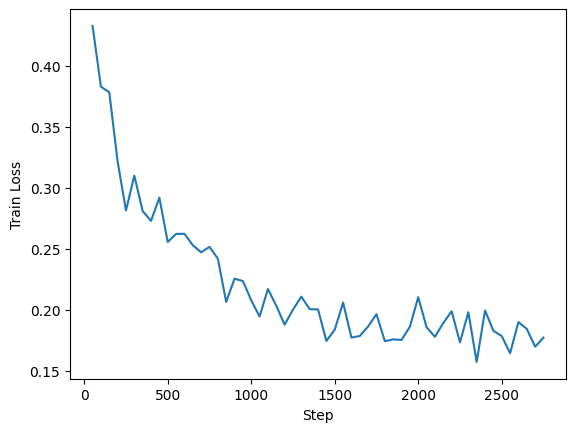

In [17]:
import os

import matplotlib.pyplot as plt
import pandas as pd


def plot_train_loss(logfile: str) -> None:
    """Plot the training loss from a PyTorch Lightning log file."""
    print(f"logfile={logfile}")
    log = pd.read_csv(filepath_or_buffer=logfile)
    plt.plot(log["step"], log["train_loss"])
    plt.xlabel("Step")
    plt.ylabel("Train Loss")
    plt.show()


# Construct the path to the most recent version directory.
most_recent_metrics_file = os.path.join(
    logger.save_dir, logger.name, f"version_{logger.version}", "metrics.csv"
)

# Plot the training loss.
plot_train_loss(logfile=most_recent_metrics_file)

Explained variance by each component: [0.10087213 0.05360623 0.04066889 0.03173844 0.02318322 0.01775565
 0.01467427 0.0140072  0.01220267 0.01190174 0.01079438 0.01026233
 0.00973306 0.00945283 0.00914858 0.00865552 0.00846762 0.00840177
 0.00804445 0.00793435 0.00781938 0.00776357 0.007618   0.00754525
 0.00743223 0.00741575 0.00727546 0.00724431 0.00719137 0.00710989
 0.00704571 0.00691995 0.00688015 0.00685896 0.00680267 0.00677903
 0.00673324 0.00669672 0.006663   0.00662441 0.00660703 0.00655051
 0.00652751 0.00651158 0.00643025 0.00642059 0.00636383 0.00632238
 0.00630273 0.00625043]
Cumulative variance explained by top 50 components: 0.61821115


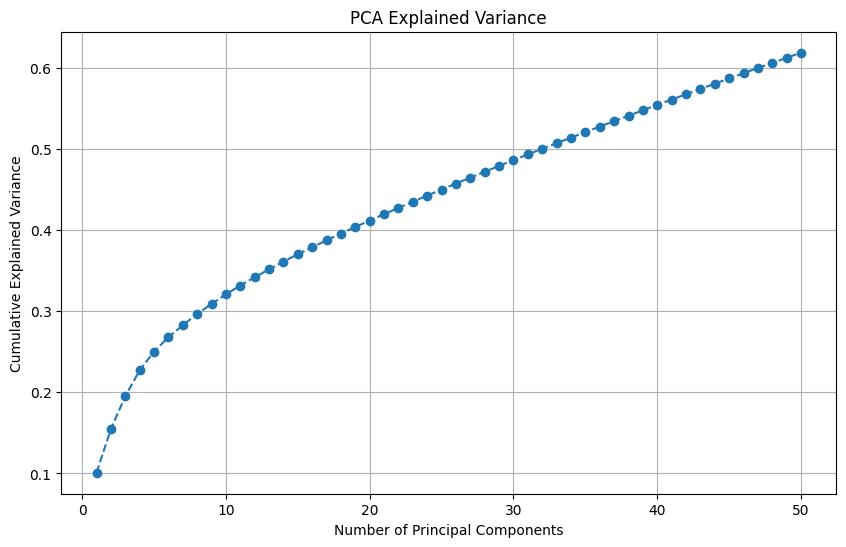

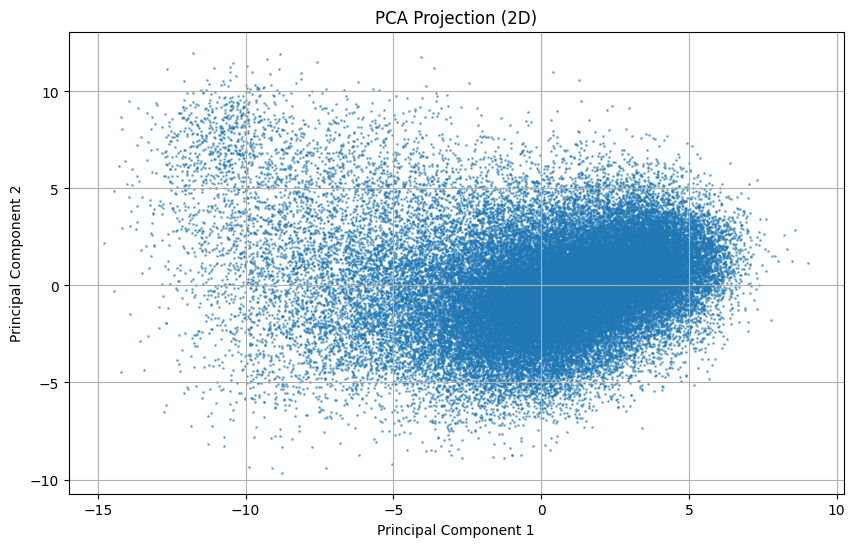

In [27]:
X_dense = adata_single_top_genes.X.toarray()  # convert to dense if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dense)

# PCA
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

print("Explained variance by each component: " + str(explained_variance_ratio))
print("Cumulative variance explained by top " + str(n_components) + " components: " + str(cumulative_variance[-1]))

# plot variance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# optionally project the data to the first two components
X_pca_2D = X_pca[:, :2]

# scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_2D[:, 0], X_pca_2D[:, 1], alpha=0.5, s=1)  # adjust markers based on dataset size
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D)')
plt.grid()
plt.show()

c:\Users\Yucel\Documents\__WS 24-25\AMLG\AMLG-Course-Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Yucel\AppData\Local\Temp\ipykernel_5940\2999900513.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


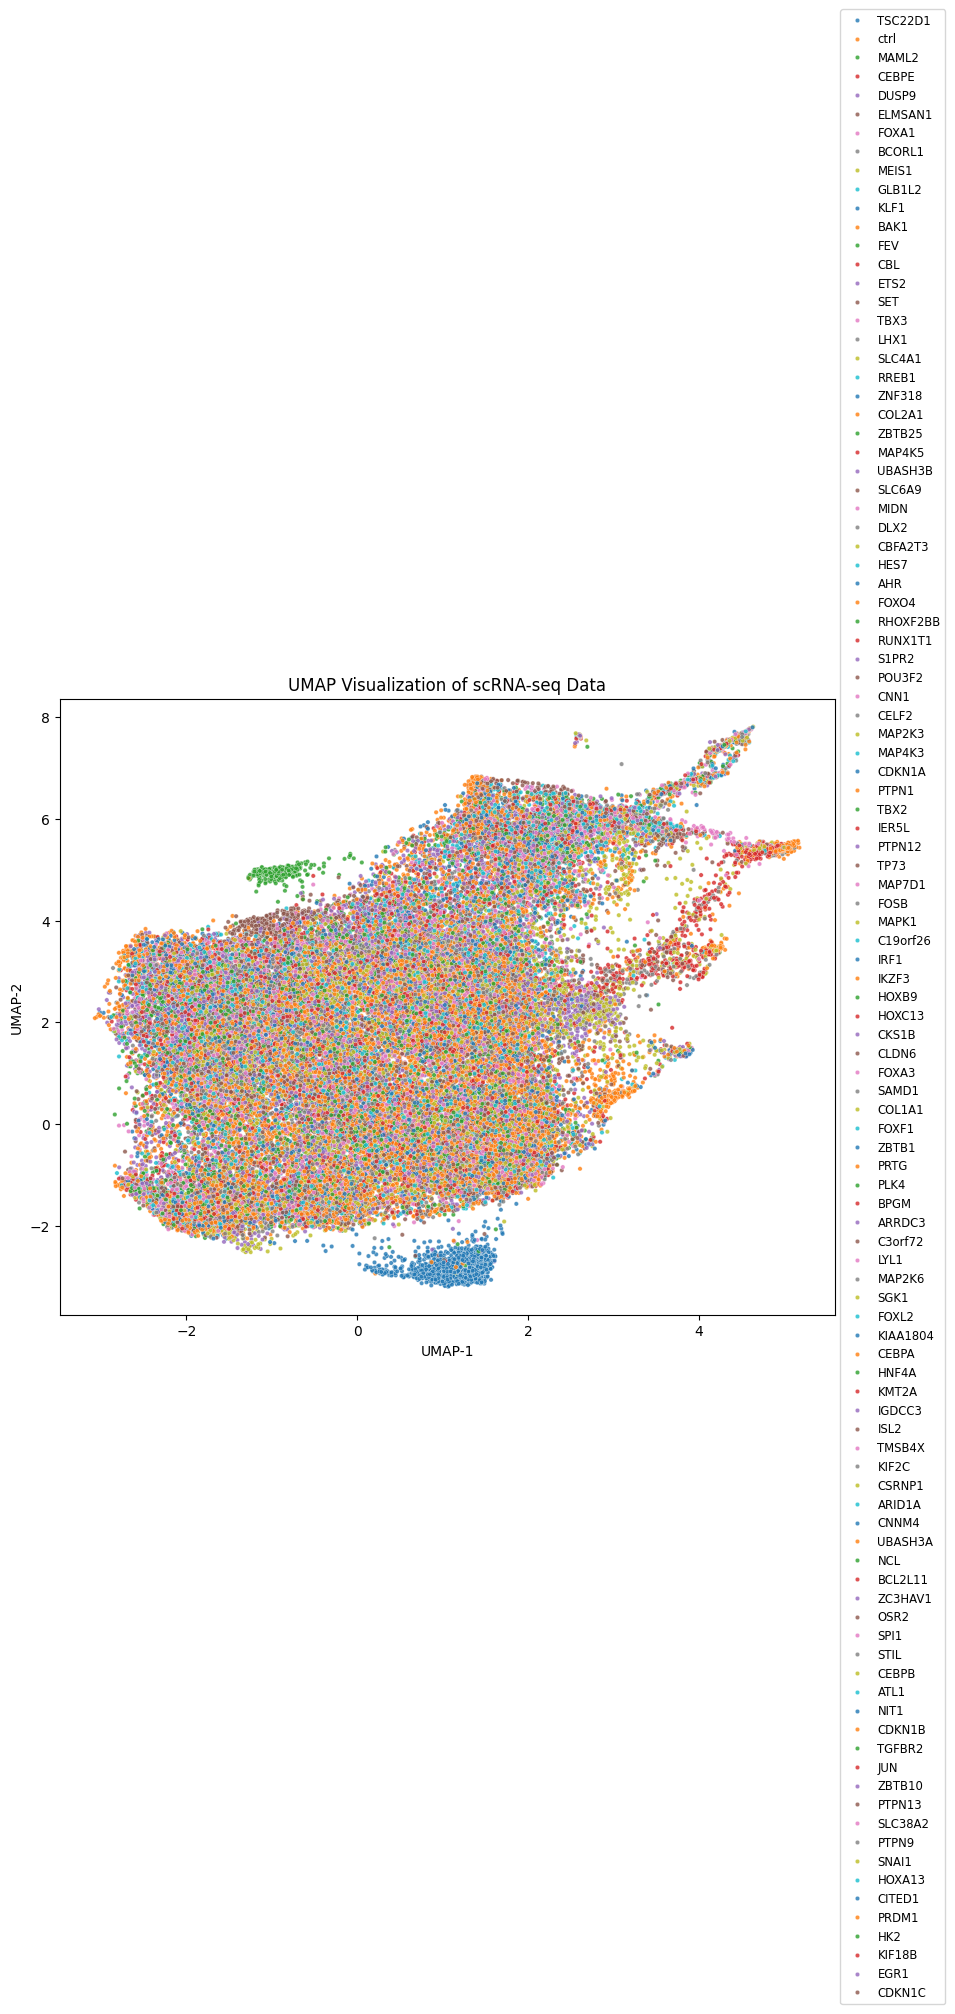

In [ ]:
# normalize and standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(adata_single_top_genes.X.toarray())  # top genes data

#reduce to intermediate dimensions
pca = PCA(n_components=50)  # reduce to 50 dimensions as a preprocessing step
X_pca = pca.fit_transform(X_scaled)

# reduce dimensions for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)  # for 2d visualization
X_umap = umap_reducer.fit_transform(X_pca)

# plot UMAP results
# add labels if available for coloring
adata_single.obs['umap-1'] = X_umap[:, 0]
adata_single.obs['umap-2'] = X_umap[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=adata_single.obs['umap-1'], 
    y=adata_single.obs['umap-2'],
    hue=adata_single.obs['condition_fixed'],  # color by condition if relevant
    palette='tab10', 
    s=10, 
    alpha=0.8
)
plt.title("UMAP Visualization of scRNA-seq Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize='small')
plt.tight_layout()
plt.show()


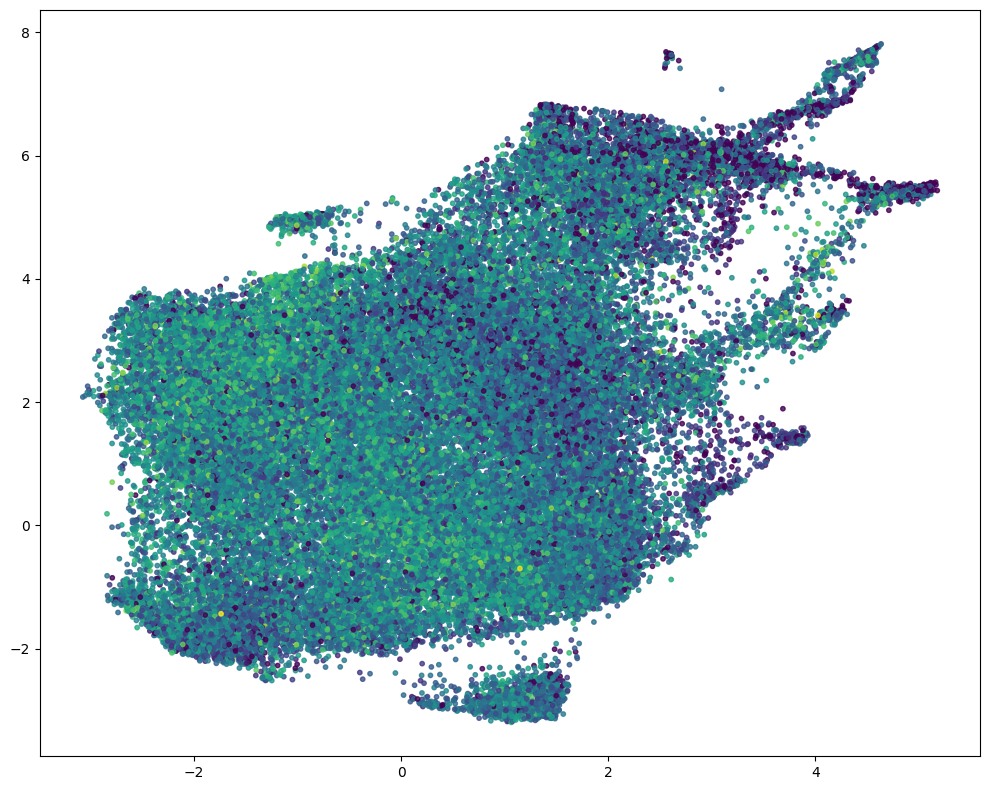

In [47]:
# choose gene name then get the dataset name of the gene
gene_name = "HIST1H1C"
feature_name = adata_single.var[adata_single.var['gene_name'] == gene_name].index[0]
feature_values = adata_single[:, feature_name].X.toarray().flatten()

# normalize feature values for better visualization
normalized_feature_values = (feature_values - feature_values.min()) / (feature_values.max() - feature_values.min())

# heatmap plot of UMAP
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    x=adata_single.obs['umap-1'],
    y=adata_single.obs['umap-2'],
    c=normalized_feature_values,  # color intensity
    cmap='viridis',               # colormaps: viridis, plasma, coolwarm
    s=10,                         # marker size
    alpha=0.8                     # transparency
)
# plt.colorbar(sc, label=f"{gene_name} Expression")  # add colorbar
# plt.title(f"UMAP Heatmap of gene {gene_name}")
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


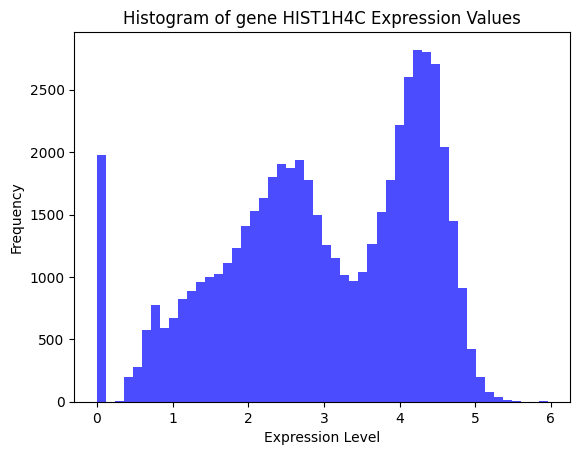

In [34]:
plt.hist(feature_values, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of gene " + str(gene_name) + " Expression Values")
plt.xlabel("Expression Level")
plt.ylabel("Frequency")
plt.show()

Choose one of the following tasks:

**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.

**PCA:**
- Linear method that reduces dimensionality by finding new axes (principal components) that capture max variance in the data

Pros:
- Fast and efficient, it's cheap and works well with large datasets
- Linear interpretability, easier to interpret
- Deterministic, always produces the same results 
  
Cons:
- Limited to linear relationship, may fail fail to capture complex patterns
- Not ideal for clustering, 

Use Case:
- Initial exploration analysis, data preprocessing to reduce dimensions before applying other methods

**t-SNE:**
- t-SNE(t-Distributed Stochastic Neighbor Embedding) maps high dimensional data to a lower-dimensional space by focusing on preserving the local structure (relations between nearby points)

Pros:
- Great for visualizing clustes, excels at showing sperations between clusters
- Nonlinear capability, can capture complex relations

Cons:
- Expensive, can be slow for large datasets
- Non-deterministic, different runs can yield different results
- More focused on local structures, global relations can be distorted
- Not scalable, struggles with datasets containing tens of thousands of points
- Not deterministic

Use Case:
- Visualizing scRNA-seq data when clusters are important to identify distinct cell types

**UMAP:**
- Also non-linear and focuses on preserving both local and global structures in the data. It builds a graph representation of the data and optimizes the embeddings in lower dimensional space

Pros:
- Preserves both local and global structure, more balanced compared to t-SNE
- Faster than t-SNE, scales better with large datasets

Cons:
- Hyperparameter tuning, needs careful adjustment of parameters (n_neighnors, min_dist) to get optimal results
- Harder to interpret compared to PCA
- Not deterministic, at least without a seed

Use Case:
- Balancing speed, scalability and data cluster visualization in scRNA-seq analysis